# Regression

## Prepare the Environment

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [15]:
# Import user-defined modules
import sys
from pathlib import Path
SRC_DIR = Path.cwd().parent / "src"
sys.path.append(str(SRC_DIR))

import data_utils

# Set global variables
RAW_DATA_DIR, PROCESSED_DATA_DIR = data_utils.get_data_directories()

Data directories successfully set.


### Load the Dataset

In [16]:
X = pd.read_csv(f"{PROCESSED_DATA_DIR}/scaled_encoded_global_dataset.csv")
raw = pd.read_excel(f"{RAW_DATA_DIR}/student_habits_performance.xlsx")
y = raw["exam_score"]

## Regression Model Training

We trained three (3) regression models i.e. linear regression, decision tree, and random forest. We used Grid Search to train the models with varying hyperparameters that we tuned. The dataset is split into 90-10 ratio and trained with K-fold cross validation at k=5 and a holdout test set. We created a function that evaluates the model with R2, mean absolute error, and root mean squared error.

In [24]:
# === Evaluation Function ===
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n{name} Evaluation:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    return {'model': name, 'r2': r2, 'mae': mae, 'rmse': rmse}

In [25]:
model_configs = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5]
        }
    }
}

In [26]:
def get_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_
        if importances.ndim > 1:
            importances = importances[0]
    else:
        return None

    return pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)


In [27]:
def run_regression_models(X, y, feature_names=None, test_size=0.1, cv_folds=5):
    results = []
    importances = {}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    for name, config in model_configs.items():
        print(f"\nTraining {name}...")

        if config['params']:
            grid = GridSearchCV(
                config['model'],
                config['params'],
                cv=KFold(n_splits=cv_folds, shuffle=True, random_state=42),
                scoring='r2',
                n_jobs=-1
            )
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"Best Params for {name}: {grid.best_params_}")
        else:
            best_model = config['model']
            best_model.fit(X_train, y_train)

        result = evaluate_model(name, best_model, X_test, y_test)
        results.append(result)

        if feature_names is not None:
            importance_df = get_feature_importance(best_model, feature_names)
            if importance_df is not None:
                importances[name] = importance_df

    return pd.DataFrame(results), importances


# Best Regression Model
The best regression model that we found is linear regression with R2 of 0.882, MAE of 4.10, and RMSE of 5.18. This model, just like the other best models we've trained for both decision tree and random forest suggests that the number of study hours per day is the mai ndeterminant of passing an examination, followed by a sharp decline for the mental health rating, and then exercise frequency. 

In [28]:
cleaned_df = pd.read_csv(f"{PROCESSED_DATA_DIR}/cleaned_dataset.csv")
feature_names = data_utils.preprocessor(cleaned_df)[1]
results_df, model_importances = run_regression_models(X, y, feature_names=feature_names)

# Results summary
print("\nFinal Comparison Table:")
print(results_df.sort_values(by='r2', ascending=False))

# Show top features from Random Forest
# Show top features for all models that support feature importances
for model_name, importance_df in model_importances.items():
    print(f"\n{model_name} Top Features:")
    print(importance_df.head(10))



Training Linear Regression...

Linear Regression Evaluation:
R² Score: 0.8822
MAE: 4.1036
RMSE: 5.1812

Training Decision Tree...
Best Params for Decision Tree: {'max_depth': 5, 'min_samples_split': 10}

Decision Tree Evaluation:
R² Score: 0.6668
MAE: 6.8478
RMSE: 8.7130

Training Random Forest...
Best Params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Evaluation:
R² Score: 0.8297
MAE: 4.9412
RMSE: 6.2288

Final Comparison Table:
               model        r2       mae      rmse
0  Linear Regression  0.882188  4.103586  5.181170
2      Random Forest  0.829726  4.941165  6.228832
1      Decision Tree  0.666823  6.847842  8.713044

Linear Regression Top Features:
                          feature  importance
1        num__study_hours_per_day   14.013177
5       num__mental_health_rating    5.569141
4         num__exercise_frequency    2.838456
3                num__sleep_hours    2.492102
2      num__attendance_percentage    1.3292

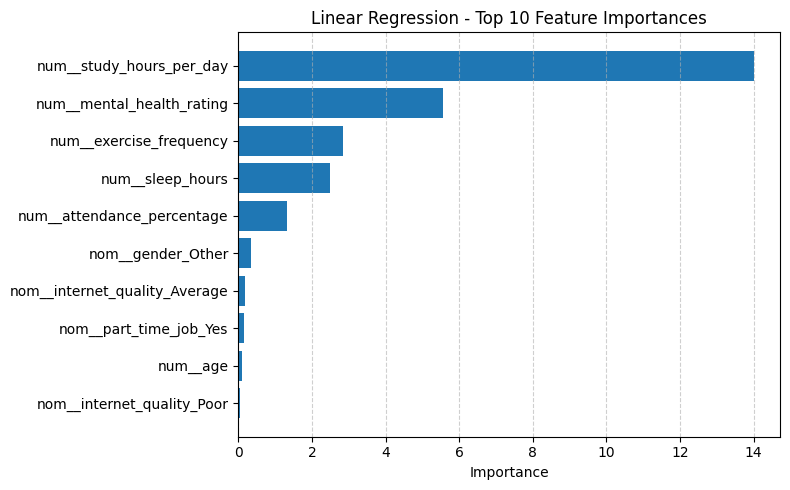

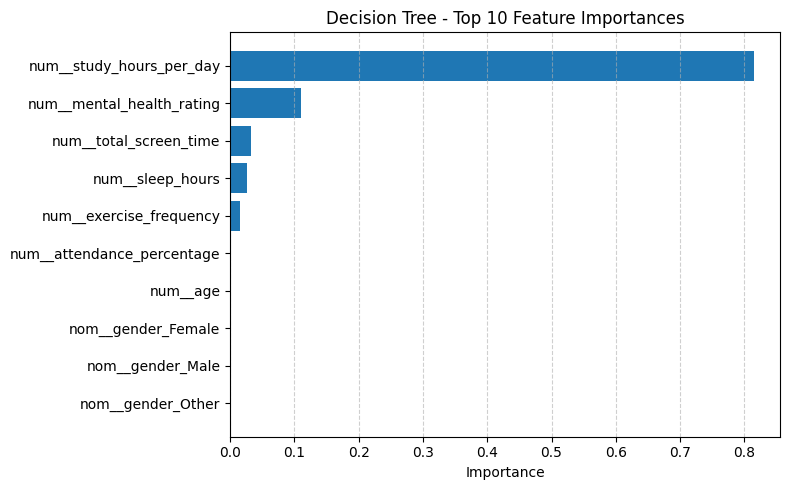

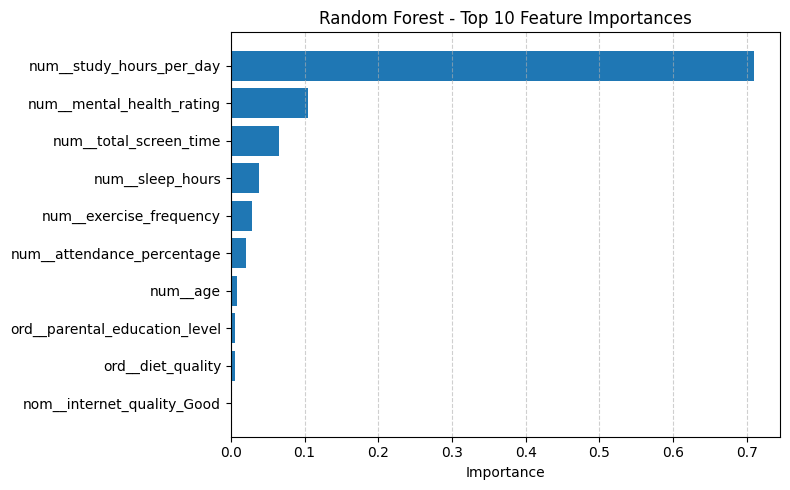

In [29]:
import matplotlib.pyplot as plt

def plot_model_importances(model_importances, top_n=10):
    for model_name, importance_df in model_importances.items():
        top_features = importance_df.head(top_n)
        plt.figure(figsize=(8, 5))
        plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
        plt.xlabel("Importance")
        plt.title(f"{model_name} - Top {top_n} Feature Importances")
        plt.tight_layout()
        plt.grid(True, axis='x', linestyle='--', alpha=0.6)
        plt.show()

# Call this after running the model
plot_model_importances(model_importances)
